<h1>Raster Fairy</h1>
<p>Version 1.0<br/>Author: Mario Klingemann | @Quasimondo</p>
<p>The purpose of Raster Fairy is to transform any kind of 2D point cloud into a regular raster whilst trying to preserve the neighborhood relations that were present in the original cloud. A typical use case is if you have a similarity clustering of images and want to show the images in a regular table structure.</p>
<p>Yes, the name is a bit silly. So if you use this algorithm for serious academic purposes and fear that a citation containing "Raster Fairy" makes your paper look less serious, you can also call it "RF-Transform". But I'd appreciate it if you cite it when you use it. Well, actually I insist. </p>
<p>This is how Raster Fairy transforms a t-sne clustering to a rectangular grid:</p>

In [4]:
from IPython.display import Image
Image(url="../rf_transform_1.gif")

Let's start by creating an example dataset consisting of 4900 random RGB points and calculate a 2D t-sne embedding from it. Of course you can use any other clustering method or whatever 2D points you have lying around. 

/home/quasimondo/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


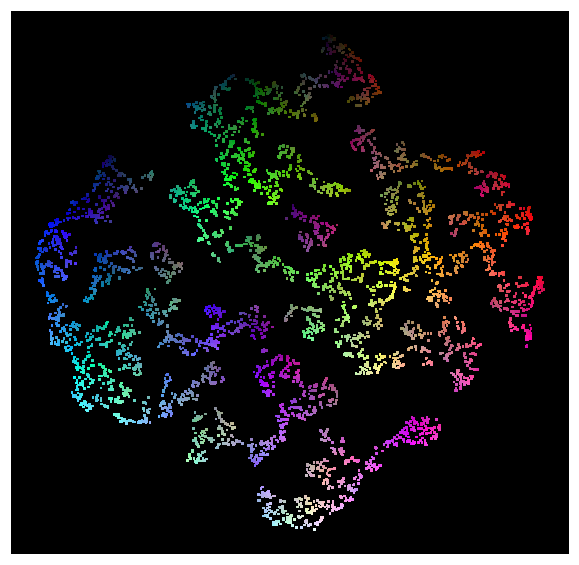

In [3]:
# just some basic setup for the purpose of this demo:
%matplotlib inline  
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


from sklearn.manifold import TSNE
#alternative you can use bh_sne:
#from tsne import bh_sne


# generate a set of 4900 random 3D points
totalDataPoints = 4900 
dataPoints = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints,3))

# create a t-sne embedding in 2D (we have to clone the array since bh_sne changes the original data)
# The bh_sne repository can be found here: https://github.com/danielfrg/tsne
#xy = bh_sne(dataPoints.copy())

xy = TSNE().fit_transform(dataPoints)


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()


Now we want to transform this cloud into a rectangular table. So the first question is: what dimensions should this table have so that it can hold 4900 elements? Raster Fairy has a convenient utility function that will give you all possible x*y combinations for a given number of target cells. The returned list is sorted in descending order from the most square proportion to the most elongated one. The shorter side is always the width, the taller side is the height and there are no duplicate proportions in there e.g. there is 20x30 but not 30x20 - you will have to flip the dimensions yourself if you need them.

In [4]:
import rasterfairy

arrangements = rasterfairy.getRectArrangements(totalDataPoints)
print arrangements

[(70, 70), (50, 98), (49, 100), (35, 140), (28, 175), (25, 196), (20, 245), (14, 350), (10, 490), (7, 700), (5, 980), (4, 1225), (2, 2450), (1, 4900)]


Ah, isn't that nice - 4900 elements can be conveniently arranged in a square table of 70x70. To get a list of the new coordinates that will map the original points to a grid we use the transformPointCloud2D() method and pass in the desired rect as a (width,height) tulple.

if you do not provide a target, Raster Fairy will first test if the number of data points allows for a well-proportioned rectangular grid. If the number of data points happens to be a prime number or does only split up into a a very tall table it will fall back to a square table and leave some cells in the bottom row empty.

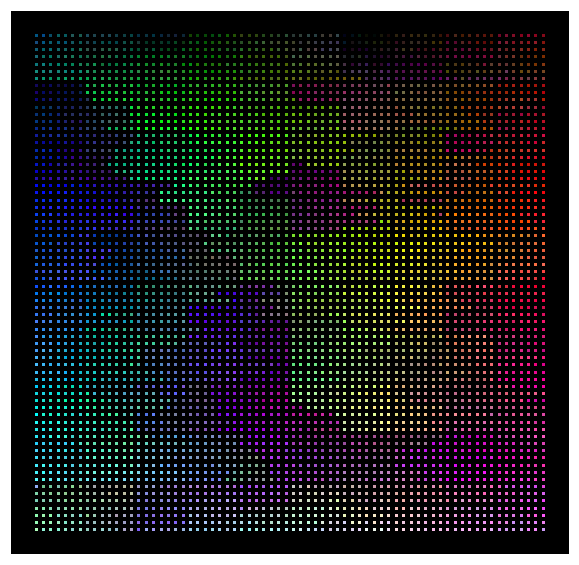

In [5]:
grid_xy, (width, height) = rasterfairy.transformPointCloud2D(xy,target=arrangements[0])

#for the most square rectangular grid you could also leave the target empty:
#grid_xy = rasterfairy.transformPointCloud2D(xy)

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

Another utility function allows to create a circular mask. Circular masks are a bit tricky since the number of grid points they produce will probably not match the number of data points in your set (it's a pixel circle, so it does not scale smoothly but in steps). Which is why there is an automatic fix option that adds or removes random grid points to match the number of desired data points. You can also disable the random point fix in which case the cells will be filled until there are no more data points left and the remaining cells will stay empty, usually it's the cells at the bottom. Both solutions are not perfect, it is probably the best idea to remove a few data points instead.

If the width*height of the raster mask is smaller than the amount of data points the transformPointCloud2D will return with an error - make sure that the area of the mask is big enough to hold all data points.

In [9]:
axis_bgradius,adjustmentFactor,count = rasterfairy.getBestCircularMatch(totalDataPoints)

print "The smallest circle that can hold",totalDataPoints,"has a radius of",radius,"and will fit",count,"points"

#the adjustmentFactor is a value between 0.0 and 1.0 that controls
#if a pixel that is on the edge of the circle will be included or not
arrangement = rasterfairy.getCircularArrangement(radius,adjustmentFactor)
rasterMask = rasterfairy.arrangementToRasterMask(arrangement)

#in this example the random auto adjust has been turned off
grid_xy, (width, height) = rasterfairy.transformPointCloud2D(xy,target=rasterMask,autoAdjustCount = False)

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xlim([0.0,max(rasterMask['width'],rasterMask['height'])])
ax.axes.set_ylim([0.0,max(rasterMask['width'],rasterMask['height'])])
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

 The smallest circle that can hold 4900 has a radius of 39 and will fit 4905 points


KeyboardInterrupt: 

Raster Fairy knows several other arrangements which are either symmetric or triangular. So if for a given number of data points there is no nicely proportioned rectangular grid there is often an alternative that looks good. The getArrangements() method returns all grid variations that are available for a number of points. Like the rectangle method it returns the arrangements in descending order starting from the most square proportions. Some of the patterns are in a hexagonal packing - if you have no use for those you can switch them off by passing includeHexagonalArrangements=False. Arrangements have to be converted to a raster mask to be used in the transformPointCloud2D() method - using either the arrangementListToRasterMasks() for a list of arrangements or arrangementToRasterMask() for a single arrangement.

Type: alternating 	Proportion: 70 x 71 	Hexagonal: False
Type: alternating 	Proportion: 72 x 69 	Hexagonal: False
Type: alternating 	Proportion: 62 x 81 	Hexagonal: True
Type: alternating 	Proportion: 51 x 99 	Hexagonal: True
Type: symmetric 	Proportion: 71 x 139 	Hexagonal: True
Type: triangular 	Proportion: 139 x 70 	Hexagonal: False
Type: symmetric 	Proportion: 117 x 47 	Hexagonal: True
Type: alternating 	Proportion: 42 x 121 	Hexagonal: True
Type: alternating 	Proportion: 121 x 41 	Hexagonal: True
Type: symmetric 	Proportion: 140 x 41 	Hexagonal: False
Type: alternating 	Proportion: 150 x 33 	Hexagonal: True
Type: alternating 	Proportion: 30 x 169 	Hexagonal: False
Type: alternating 	Proportion: 170 x 29 	Hexagonal: False
Type: alternating 	Proportion: 183 x 27 	Hexagonal: True
Type: alternating 	Proportion: 24 x 213 	Hexagonal: False
Type: alternating 	Proportion: 214 x 23 	Hexagonal: False
Type: alternating 	Proportion: 22 x 239 	Hexagonal: True
Type: alternating 	Proportion: 18 

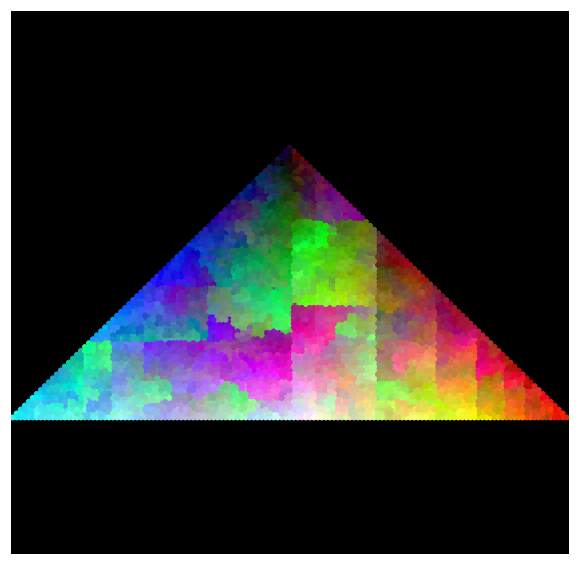

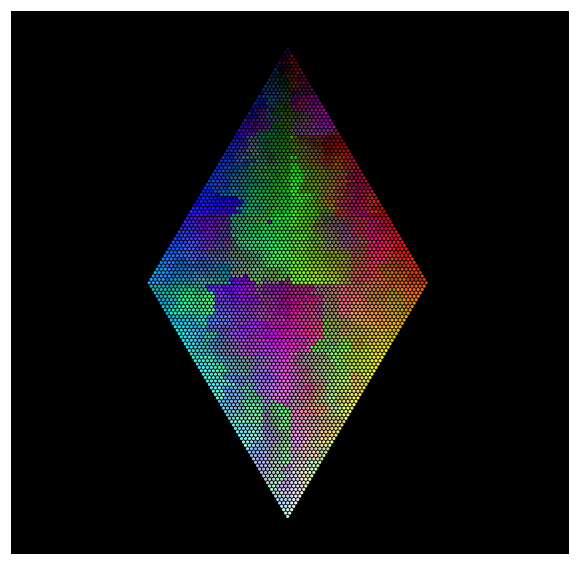

In [11]:
arrangements = rasterfairy.getArrangements(totalDataPoints)
masks = rasterfairy.arrangementListToRasterMasks(arrangements)
for mask in masks:
    print "Type:",mask['type'],"\tProportion:",mask['width'],"x",mask['height'],"\tHexagonal:",mask['hex']
    
# let's pick the triangular one
rasterMask = masks[5]
grid_xy, (width, height) = rasterfairy.transformPointCloud2D(xy,target=rasterMask)

#center the result in the matplotlib canvas
dim = max(width,height)
grid_xy[:,0] += 0.5 * (dim-width)+0.5
grid_xy[:,1] += 0.5 * (dim-height)+0.5

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xlim([0.0,dim])
ax.axes.set_ylim([0.0,dim])
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none')    
plt.show()

# and one of the hexagonal arrangements:
rasterMask = masks[4]
grid_xy, (width, height) = rasterfairy.transformPointCloud2D(xy,target=rasterMask)

#center the result in the matplotlib canvas including an ugly fix for the hexagonal height
dim = max(width,height)
grid_xy[:,0] += 0.5 * (dim-width)+0.5
grid_xy[:,1] += 0.5 * (dim-height*0.866025)+0.5

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xlim([0.0,dim])
ax.axes.set_ylim([0.0,dim])
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none', s=10.0)    
plt.show()

And yes, you can get even more playful by using a monochrome bitmap as the grid target! I know - data visualization purists will turn in their graves. Like with the circle it might be a challenge to match the number of black pixels with the number of data points which is why there is also an automatic fix option that adds or removes random pixels. In the next version I will try to add a method that is a bit smarter about addind and removing points so it's less random sprinkles.

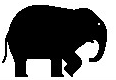

5146 black pixels in map


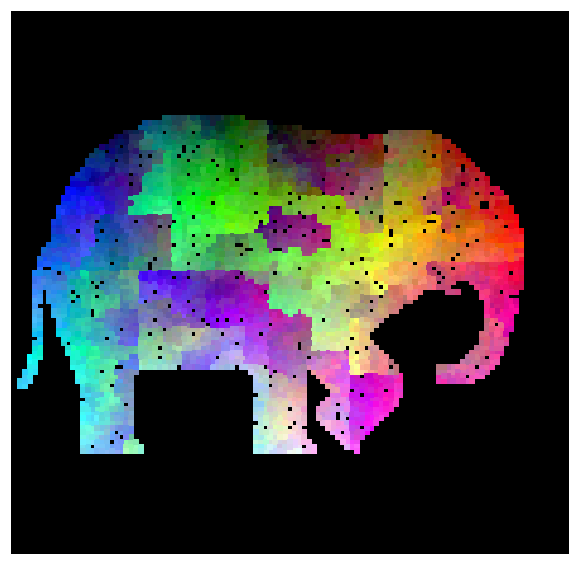

In [6]:
import PIL.Image as PImage

img = PImage.open("../elephant.png")
display(img)

rasterMask = rasterfairy.getRasterMaskFromImage(img)

#if you are just interested in knowing how many data points a bitmap has you can call this method:
print rasterMask['count'],"black pixels in map"

grid_xy,(width,height) = rasterfairy.transformPointCloud2D(xy,target=rasterMask,autoAdjustCount = True)

#center the result in the matplotlib canvas
dim = max(width,height)
grid_xy[:,0] += 0.5 * (dim-width)
grid_xy[:,1] += 0.5 * (dim-height)

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xlim([0.0,dim])
ax.axes.set_ylim([0.0,dim])
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none',marker='s')    
plt.show()



And finally here's how to create a animated gif that shows the transition. It uses moviepy for exporting the animation.

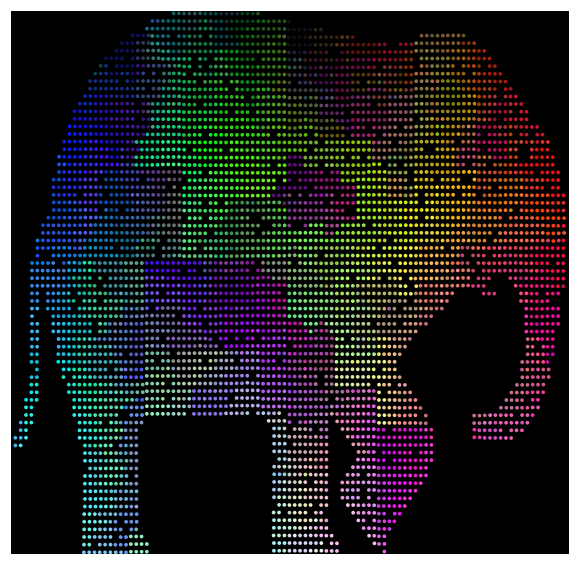


[MoviePy] Building file ../rf_transform_demo.gif with imageio


100%|██████████| 101/101 [00:08<00:00, 12.48it/s]


In [14]:
import io
from moviepy.editor import *
from sklearn.cluster import KMeans
import PIL.Image as PImage
from IPython.display import Image, clear_output

pointCount = len(xy)
# some color reduction since the NeuQuant color reduction of images2gif does a bad job in this case:
kmeans = KMeans(n_clusters=min(255,pointCount), random_state=0).fit(dataPoints)
reducedColors = kmeans.cluster_centers_[kmeans.predict(dataPoints)]

images = []

# a bit of coordinate normalization so the coordinates are in the same range:
px_from = grid_xy[:,0] - min(grid_xy[:,0])
py_from = grid_xy[:,1] - min(grid_xy[:,1])

px_from /= max(px_from)
py_from /= max(py_from)

px_to = xy[:,0] - min(xy[:,0])
py_to = xy[:,1] - min(xy[:,1])

px_to /= max(px_to)
py_to /= max(py_to)

# fixing the proportions:
if ( width>height):
    py_to = py_to * float(height) / float(width) + 0.5 * (1.0 - float(height) / float(width))
else:
    px_to = px_to * float(width) / float(height) + 0.5 * (1.0 - float(width) / float(height))


steps = 50

for i in range(steps*2):
    dx = []
    dy = []
    t = 1.0- abs(1.0 * i / (steps-1)-1.0) #tsteps[steps]
    for j in range( pointCount ):
        dx.append( (1.0-t)*px_from[j] + t*px_to[j])
        dy.append( (1.0-t)*py_from[j] + t*py_to[j] )
    
    fig2 = plt.figure(figsize=(10.0,10.0))
    ax = fig2.add_subplot(1, 1, 1)
    ax.set_facecolor('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.scatter(dx,dy, c = reducedColors,  edgecolors='none',s=14.0) #,marker='s'
    ax.axes.set_xlim([-0.01,1.01])
    ax.axes.set_ylim([-0.01,1.01])
    ax.invert_yaxis()
    clear_output(wait=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    images.append( np.array(PImage.open(buf)) )
    
    #in case you want to rather export a series of PNGs:
    #plt.savefig('clusters/cluster'+"%03d" % (i+steps,)+'.png')
    plt.show()
    
    
clip = ImageSequenceClip(images,fps=25)
clip.write_gif("../rf_transform_demo.gif")                 
Image(url="../rf_transform_demo.gif")
    
    